# W261 Final Project EDA

### Notebook Set-Up

In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from scipy.sparse import csr_matrix

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "w261_finalproject"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

## Load Data

In [5]:
# make a data folder & download red & white wine files
!mkdir data
#!wget -q -O data/reds.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
#!wget -q -O data/whites.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

mkdir: cannot create directory `data': File exists


In [ ]:
!head data/train.txt

In [16]:
header = !head -n 1 data/train.txt
header = header[0]
header

'0\t1\t1\t5\t0\t1382\t4\t15\t2\t181\t1\t2\t\t2\t68fd1e64\t80e26c9b\tfb936136\t7b4723c4\t25c83c98\t7e0ccccf\tde7995b8\t1f89b562\ta73ee510\ta8cd5504\tb2cb9c98\t37c9c164\t2824a5f6\t1adce6ef\t8ba8b39a\t891b62e7\te5ba7672\tf54016b9\t21ddcdc9\tb1252a9d\t07b5194c\t\t3a171ecb\tc5c50484\te8b83407\t9727dd16'

In [ ]:
header.split('\t')

In [32]:
header2 = !head -n 2 data/train.txt
header2 = header2[1]
np.array(header2.split("\t")[:14], dtype = np.float)

ValueError: could not convert string to float: 

In [5]:
original_trainRDD = sc.textFile('data/train.txt')
original_testRDD = sc.textFile('data/test.txt')

## Parse and Sample Training Data

In [6]:
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    raw_values = line.split('\t')
    label = [int(raw_values[0])]
    numerical_values = list(pd.Series(raw_values[1:14]).apply(pd.to_numeric))
    categorical_values = list([str(idx)+"_MISSINGVALUE" if str(value)=="" else str(idx)+"_"+str(value) for idx,value in enumerate(raw_values[14:])])
    return(numerical_values + categorical_values + label)

In [7]:
def parse_numbers(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split('\t')[:14])
    label,features = fields[0], fields[1:]
    return(features, label)

In [8]:
def parse_categories(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split('\t'))
    label,features = fields[0], fields[14:]
    return(features, label)

In [9]:
trainRDD, heldOutRDD = original_trainRDD.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 9167871 records for evaluation and assigned 36672746 for training.


In [10]:
numeric_trainRDDCached = trainRDD.map(parse_numbers).cache()
categorical_trainRDDCached = trainRDD.map(parse_categories).cache()

In [11]:
numeric_sample = np.array(numeric_trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 1000))
numeric_sample_df = pd.DataFrame(np.array(numeric_sample))#, columns = FIELDS)

In [42]:
numeric_sample_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,6,0,68,31,5,29,6,31,31,1,1,0,28,0
1,,0,7,2,2815,237,4,11,222,,4,,2,1
2,0,12,31,15,1889,212,8,42,283,0,3,0,38,1
3,0,10,178,2,833,331,14,25,75,0,1,,7,0
4,,44,14,1,72,,0,1,1,,0,,1,0


In [12]:
categorical_sample = np.array(categorical_trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 1000))
categorical_sample_df = pd.DataFrame(np.array(categorical_sample))#, columns = FIELDS)

In [43]:
categorical_sample_df.head()#26 features + label

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,05db9164,8947f767,70654e99,0c2cae44,25c83c98,7e0ccccf,753aa291,0b153874,a73ee510,733b729f,...,bd17c3da,9653bb65,a458ea53,fa041ecd,,3a171ecb,3fdb382b,010f6491,42c1aa63,1
1,68fd1e64,bce95927,928bf304,13508380,25c83c98,fbad5c96,124131fa,c8ddd494,a73ee510,a1ee64a6,...,04d863d5,21ddcdc9,b1252a9d,86470f7e,ad3062eb,3a171ecb,45ab94c8,875ea8a7,c84c4aec,1
2,05db9164,58e67aaf,1e998f2e,beb41a64,25c83c98,7e0ccccf,b796c337,0b153874,a73ee510,ec308632,...,c21c3e4c,04de9d96,b1252a9d,71191ab8,ad3062eb,c7dc6720,8cfca800,e8b83407,f99af3bd,1
3,05db9164,b80912da,6ef2aa66,20af9140,4cf72387,7e0ccccf,37726a04,5b392875,a73ee510,3b08e48b,...,7119e567,2f4b9dd2,a458ea53,98a79791,,3a171ecb,3fdb382b,e8b83407,49d68486,0
4,5a9ed9b0,4f25e98b,36fa215c,2fd8dfe4,30903e74,fe6b92e5,d5b6acf2,0b153874,a73ee510,6f085fe1,...,7ef5affa,442e81c4,a458ea53,1efc5160,ad3062eb,c7dc6720,4a78923e,001f3601,59a8035f,1


## EDA for Numerical Values

In [13]:
numeric_sample_df = numeric_sample_df.apply(pd.to_numeric)

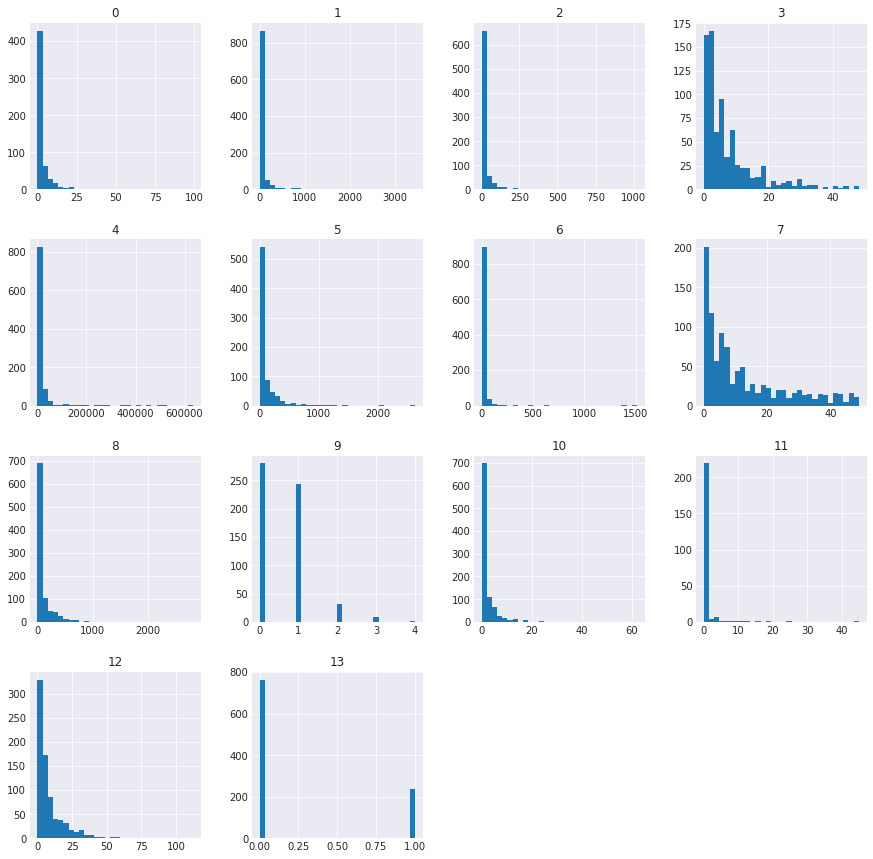

In [14]:
numeric_sample_df.hist(figsize=(15,15), bins=30)
plt.show()

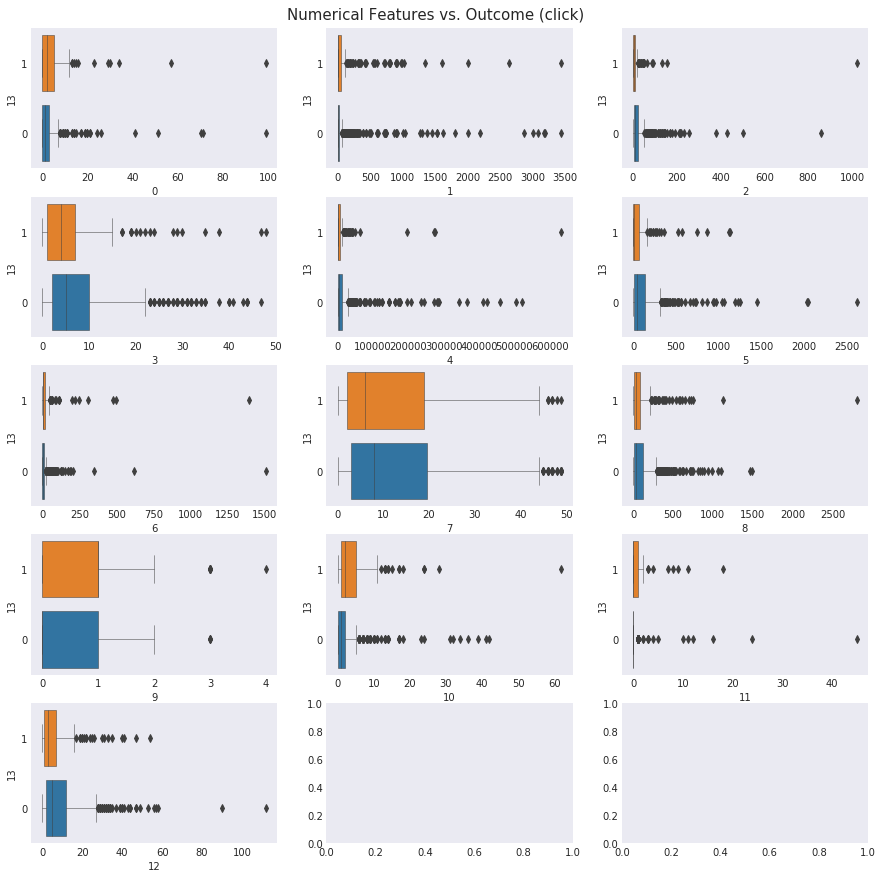

In [15]:
fig, ax_grid = plt.subplots(5, 3, figsize=(15,15))
y = numeric_sample_df.loc[:,13]#.astype("float")
for idx in range(len(numeric_sample_df.columns)-1):
    x = numeric_sample_df.loc[:,idx]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Numerical Features vs. Outcome (click)", fontsize=15, y=0.9)
plt.show()

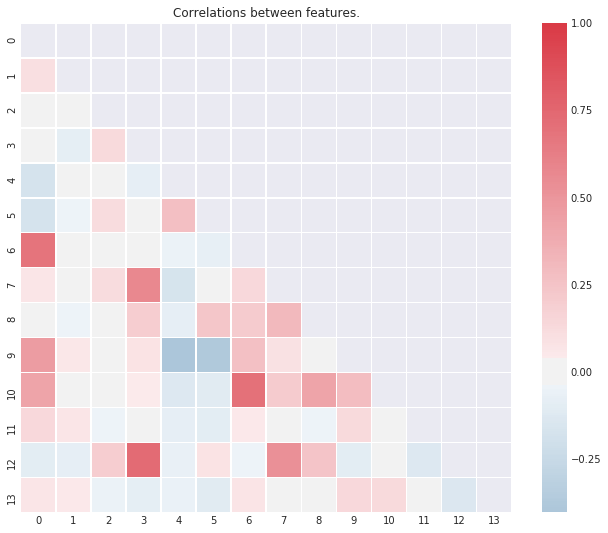

In [16]:
corr = numeric_sample_df.loc[:,:14].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

### Log Transform

In [17]:
small_constant = 0.001
log_numeric_sample_df = numeric_sample_df.apply(lambda x: x+small_constant).apply(np.log)

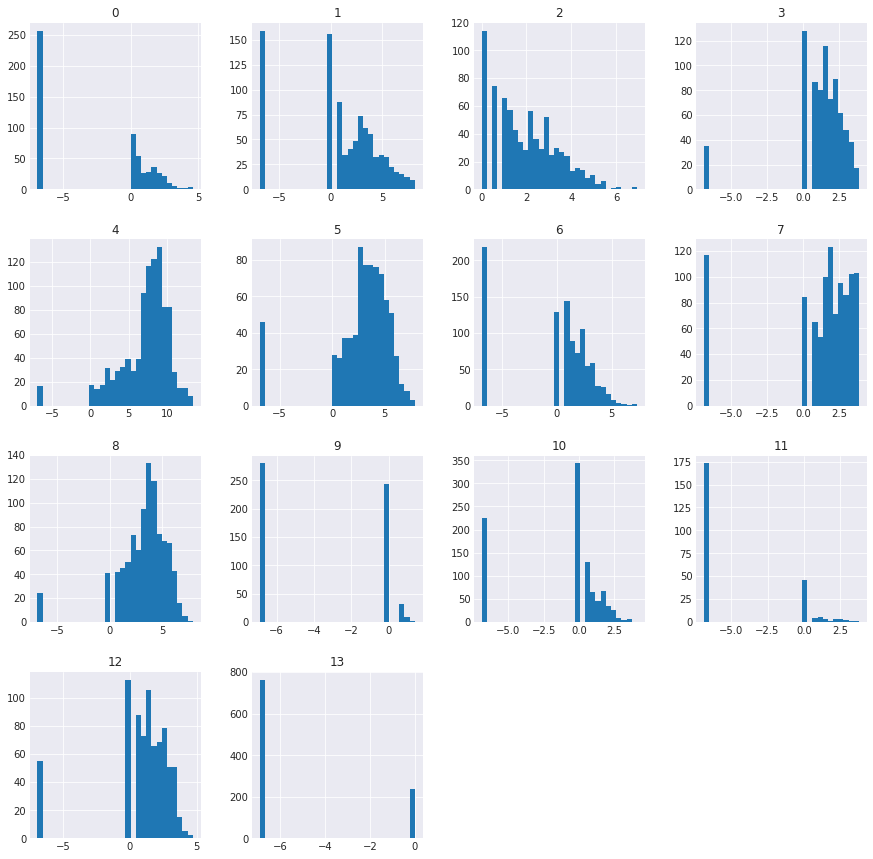

In [18]:
log_numeric_sample_df.hist(figsize=(15,15), bins=30)
plt.show()

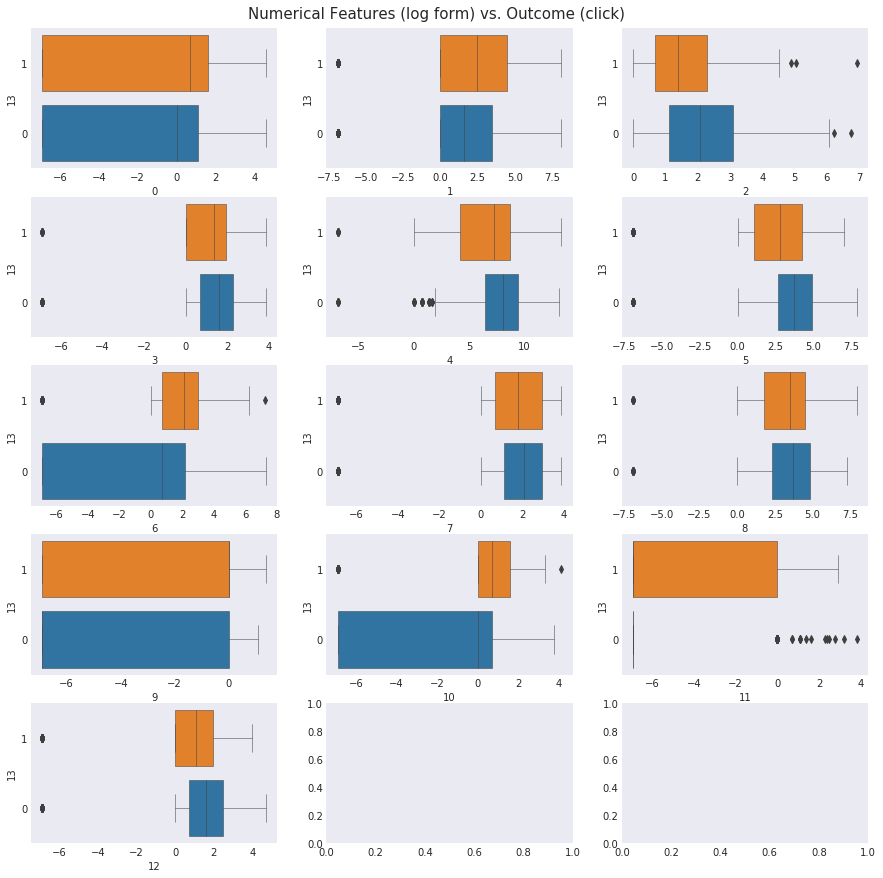

In [19]:
fig, ax_grid = plt.subplots(5, 3, figsize=(15,15))
y = numeric_sample_df.loc[:,13]#.astype("float")
for idx in range(len(numeric_sample_df.columns)-1):
    x = log_numeric_sample_df.loc[:,idx]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Numerical Features (log form) vs. Outcome (click)", fontsize=15, y=0.9)
plt.show()

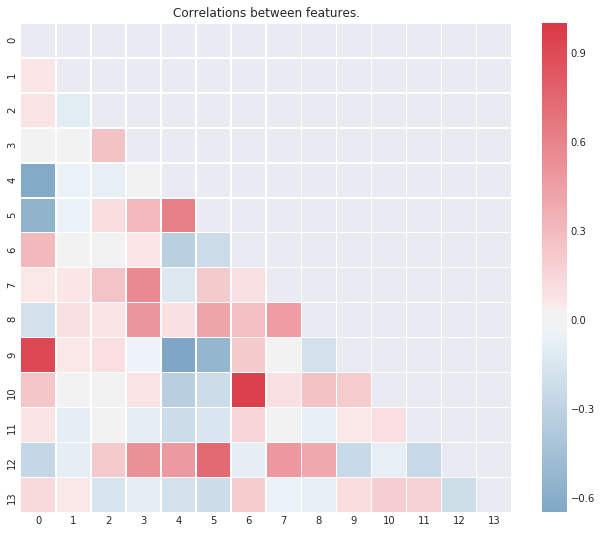

In [20]:
corr = log_numeric_sample_df.loc[:,:14].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

## How many distinct values are there in each of the categories?

In [ ]:
for feature_num in range(len(categorical_sample_df.columns)):
    print(categorical_sample_df.loc[:,feature_num].unique())

In [ ]:
total_categories = 0
for feature_num in range(len(categorical_sample_df.columns)):
    num_distinct = len(categorical_sample_df.loc[:,feature_num].unique())
    if feature_num < 26:
        total_categories += num_distinct
        print("Distinct values in categorical feature", str(feature_num+1) + ":", str(num_distinct))
print("Total categories in sample:", str(total_categories))

In [35]:
total_categories = 0
all_categorical_values = pd.Series()
for feature_num in range(len(categorical_sample_df.columns)):
    distinct_values = categorical_sample_df.loc[:,feature_num].unique()
    num_distinct = len(distinct_values)
    all_categorical_values= all_categorical_values.append(pd.Series(distinct_values))
    if '55dd3565' in distinct_values:
        print("Duplicate of 55dd3565 found in feature",feature_num+1)
    if feature_num < 26:
        total_categories += num_distinct
        print("Distinct values in categorical feature", str(feature_num+1) + ":", str(num_distinct))
print("Total categories in sample:", str(total_categories))

Distinct values in categorical feature 1: 59
Distinct values in categorical feature 2: 193
Distinct values in categorical feature 3: 756
Distinct values in categorical feature 4: 626
Distinct values in categorical feature 5: 23
Distinct values in categorical feature 6: 8
Distinct values in categorical feature 7: 701
Distinct values in categorical feature 8: 39
Distinct values in categorical feature 9: 2
Distinct values in categorical feature 10: 601
Distinct values in categorical feature 11: 579
Distinct values in categorical feature 12: 723
Distinct values in categorical feature 13: 527
Distinct values in categorical feature 14: 20
Distinct values in categorical feature 15: 579
Distinct values in categorical feature 16: 686
Distinct values in categorical feature 17: 9
Distinct values in categorical feature 18: 398
Duplicate of 55dd3565 found in feature 19
Distinct values in categorical feature 19: 115
Distinct values in categorical feature 20: 4
Distinct values in categorical feature 

### Check for Duplicates

In [33]:
all_categorical_values[all_categorical_values.duplicated()]

34            
4             
34            
34            
1             
2             
34            
0             
8     55dd3565
32            
2             
2             
dtype: object

In [34]:
all_categorical_values[all_categorical_values=='55dd3565']

6    55dd3565
8    55dd3565
dtype: object

In [36]:
all_categorical_values[all_categorical_values=='']

34    
34    
4     
34    
34    
1     
2     
34    
0     
32    
2     
2     
dtype: object

## Transformation

In [7]:
sampleRDD1, sampleRDD2 = original_trainRDD.randomSplit([0.9999,0.0001], seed = 1)
test_trainRDDCached = sampleRDD2.map(parse).cache()
test_trainRDDCached.take(1)

[[nan,
  4.0,
  50.0,
  18.0,
  3339.0,
  20.0,
  26.0,
  17.0,
  133.0,
  nan,
  2.0,
  nan,
  18.0,
  '0_09ca0b81',
  '1_09e68b86',
  '2_86c4b829',
  '3_e3d0459f',
  '4_25c83c98',
  '5_MISSINGVALUE',
  '6_7227c706',
  '7_0b153874',
  '8_a73ee510',
  '9_305a0646',
  '10_9625b211',
  '11_997a695a',
  '12_dccbd94b',
  '13_07d13a8f',
  '14_36721ddc',
  '15_c0b906bb',
  '16_e5ba7672',
  '17_5aed7436',
  '18_21ddcdc9',
  '19_a458ea53',
  '20_0cbbcc92',
  '21_MISSINGVALUE',
  '22_32c7478e',
  '23_0174dd24',
  '24_3d2bedd7',
  '25_d8ecbc17',
  0]]

In [8]:
ncol = len(test_trainRDDCached.first())
nrow = test_trainRDDCached.count()

In [9]:
nrow

4478

In [10]:
distinctValsRDD = test_trainRDDCached.flatMap(lambda line: line[13:-1]).distinct()
distinctValsRDD.count()

25676

### What is the percentage of NaN values in each numerical feature?

In [28]:
nanCounts = numericalFeatures.map(lambda line: 1.0*np.isnan(line)).reduce(lambda x,y: np.add(x,y))
nanCounts

array([1.978e+03, 0.000e+00, 9.580e+02, 9.220e+02, 1.220e+02, 9.710e+02,
       1.870e+02, 1.000e+00, 1.870e+02, 1.978e+03, 1.870e+02, 3.375e+03,
       9.220e+02])

In [36]:
nonNanCounts = numericalFeatures.map(lambda line: 1.0*~np.isnan(line)).reduce(lambda x,y: np.add(x,y))
nonNanCounts
#nonNanCountsb = sc.broadcast(nonNanCounts)

In [35]:
np.round(100*np.divide(nanCounts, np.add(nanCounts, nonNanCounts)),1)

array([44.2,  0. , 21.4, 20.6,  2.7, 21.7,  4.2,  0. ,  4.2, 44.2,  4.2,
       75.4, 20.6])

In [91]:
# part d - helper function to normalize the data (FILL IN THE MISSING CODE BELOW)
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    translation_after_standardization = 5

    numericalFeatures = dataRDD.map(lambda x: list(x[:13])).cache()

    nonNanCounts = numericalFeatures.map(lambda line: 1.0*~np.isnan(line)).reduce(lambda x,y: np.add(x,y))
    nonNanCountsb = sc.broadcast(nonNanCounts)
    
    featureMeans = numericalFeatures.reduce(lambda x,y: np.nansum(np.dstack((x, y)), 2))
    featureMeans = np.divide(featureMeans,nonNanCountsb.value)
    featureMeansb = sc.broadcast(featureMeans)
    
    featureStdev = numericalFeatures.map(lambda line: np.square(np.subtract(line, featureMeansb.value))) \
                                    .reduce(lambda x,y: np.nansum(np.dstack((x, y)), 2))
    featureStdev = np.sqrt(featureStdev/nonNanCountsb.value)
    featureStdevb = sc.broadcast(featureStdev)
    
    normedRDD = dataRDD.map(lambda x: np.add(np.divide(np.subtract(x[:13],featureMeansb.value),featureStdevb.value), translation_after_standardization).tolist()[0] + list(x[13:]))
    
    return normedRDD

In [92]:
# part d - cache normalized data (RUN THIS CELL AS IS)
normedRDD = normalize(test_trainRDDCached).cache()
#test_blah = normedRDD.first()

### Log Transform

In [97]:
logRDD = normedRDD.map(lambda x: np.log(x[:13]).tolist() + list(x[13:]))
#logRDD.first()

[nan,
 1.5546416330280177,
 1.614858026325336,
 1.8324388135638439,
 1.5658974261919119,
 1.5447893046000354,
 1.6455071185060295,
 1.6722403253403968,
 1.6258544971242836,
 nan,
 1.5791945292276104,
 nan,
 1.7750904691093639,
 '0_09ca0b81',
 '1_09e68b86',
 '2_86c4b829',
 '3_e3d0459f',
 '4_25c83c98',
 '5_MISSINGVALUE',
 '6_7227c706',
 '7_0b153874',
 '8_a73ee510',
 '9_305a0646',
 '10_9625b211',
 '11_997a695a',
 '12_dccbd94b',
 '13_07d13a8f',
 '14_36721ddc',
 '15_c0b906bb',
 '16_e5ba7672',
 '17_5aed7436',
 '18_21ddcdc9',
 '19_a458ea53',
 '20_0cbbcc92',
 '21_MISSINGVALUE',
 '22_32c7478e',
 '23_0174dd24',
 '24_3d2bedd7',
 '25_d8ecbc17',
 0]

### One-Hot Encoding

In [100]:
numerical_names = ["n00", "n01", "n02", "n03", "n04", "n05", "n06", "n07", "n08", "n09", "n10", "n11", "n12"]
category_vals = np.ones(24).tolist()

In [103]:
def convert_to_list_form(line):
    numbers = line[:13]
    categories = line[13:-1]
    label = line[-1]
    dict1 = dict(zip(numerical_names, numbers))
    dict2 = dict(zip(categories, category_vals))
    return (label, {**dict1, **dict2})

In [105]:
final_data_rdd = logRDD.map(convert_to_list_form)
final_data_rdd.first()

(0,
 {'n00': nan,
  'n01': 1.5546416330280177,
  'n02': 1.614858026325336,
  'n03': 1.8324388135638439,
  'n04': 1.5658974261919119,
  'n05': 1.5447893046000354,
  'n06': 1.6455071185060295,
  'n07': 1.6722403253403968,
  'n08': 1.6258544971242836,
  'n09': nan,
  'n10': 1.5791945292276104,
  'n11': nan,
  'n12': 1.7750904691093639,
  '0_09ca0b81': 1.0,
  '1_09e68b86': 1.0,
  '2_86c4b829': 1.0,
  '3_e3d0459f': 1.0,
  '4_25c83c98': 1.0,
  '5_MISSINGVALUE': 1.0,
  '6_7227c706': 1.0,
  '7_0b153874': 1.0,
  '8_a73ee510': 1.0,
  '9_305a0646': 1.0,
  '10_9625b211': 1.0,
  '11_997a695a': 1.0,
  '12_dccbd94b': 1.0,
  '13_07d13a8f': 1.0,
  '14_36721ddc': 1.0,
  '15_c0b906bb': 1.0,
  '16_e5ba7672': 1.0,
  '17_5aed7436': 1.0,
  '18_21ddcdc9': 1.0,
  '19_a458ea53': 1.0,
  '20_0cbbcc92': 1.0,
  '21_MISSINGVALUE': 1.0,
  '22_32c7478e': 1.0,
  '23_0174dd24': 1.0})